In [1]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV
from sklearn.ensemble import VotingRegressor, BaggingRegressor
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')

2021-12-26 19:33:23.457359: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/usr/lib/python3/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.


In [2]:
import os 
path = 'Derivatives/'
os.listdir(path)

['data_force_output.csv',
 'data_force_output_test.csv',
 'data_derivative_testing.csv',
 'data_derivative_training_x2.csv',
 'data_derivative_testing_x2.csv',
 'data_derivative_training.csv']

In [3]:
path = 'Derivatives/'
x1_train = pd.read_csv(path+'data_derivative_training.csv')
x2_train = pd.read_csv(path+'data_derivative_training_x2.csv')

y_train = pd.read_csv(path+'data_force_output.csv')
y_test = pd.read_csv(path+'data_force_output_test.csv')

x1_test = pd.read_csv(path+'data_derivative_testing.csv')
x2_test = pd.read_csv(path+'data_derivative_testing_x2.csv')

X_train = pd.DataFrame(data = np.concatenate((x1_train,x2_train),axis=1))
X_test = pd.DataFrame(data = np.concatenate((x1_test,x2_test),axis=1))
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00
1,-0.025200,-0.039939,-0.063299,-0.100320,-0.159000,-0.252000,-0.399390,-0.632990,-1.003200,-1.59,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00
2,-0.022680,-0.031951,-0.044309,-0.060193,-0.079500,-0.100800,-0.119820,-0.126600,-0.100320,0.00,0.027102,0.042953,0.068076,0.107890,0.17100,0.27102,0.42953,0.68076,1.07890,1.71
3,-0.021546,-0.028756,-0.037663,-0.048155,-0.059625,-0.070559,-0.077881,-0.075959,-0.055177,0.00,0.024392,0.034363,0.047653,0.064736,0.08550,0.10841,0.12886,0.13615,0.10789,0.00
4,0.004372,0.013100,0.029402,0.058588,0.109310,0.195550,0.339680,0.577290,0.964600,1.59,0.048213,0.070614,0.103410,0.151480,0.22212,0.32630,0.48064,0.71070,1.05630,1.58


In [4]:
from scipy import *
from scipy.linalg import norm, pinv
import math
 
from matplotlib import pyplot as plt
 
class RBF:
     
    def __init__(self, indim, numCenters, outdim):
        self.indim = indim
        self.outdim = outdim
        self.numCenters = numCenters
        self.centers = [np.random.uniform(-1, 1, indim) for i in range(numCenters)]
        self.beta = 8
        self.W = np.random.random((self.numCenters, self.outdim))
         
    def _basisfunc(self, c, d):
        assert len(d) == self.indim
        return norm(c-d)**3
     
    def _calcAct(self, X):
        # calculate activations of RBFs
        G = np.zeros((X.shape[0], self.numCenters), float)
        for ci, c in enumerate(self.centers):
            for xi, x in enumerate(X):
                G[xi,ci] = self._basisfunc(c, x)
        return G
     
    def train(self, X, Y):
        """ X: matrix of dimensions n x indim 
            y: column vector of dimension n x 1 """
         
        # choose random center vectors from training set
        rnd_idx = np.random.permutation(X.shape[0])[:self.numCenters]
        self.centers = [X[i,:] for i in rnd_idx]
         
        #print("center", self.centers)
        # calculate activations of RBFs
        G = self._calcAct(X)
        #print(G)
         
        # calculate output weights (pseudoinverse)
        self.W = np.dot(pinv(G), Y)
         
    def test(self, X):
        """ X: matrix of dimensions n x indim """
         
        G = self._calcAct(X)
        Y = np.dot(G, self.W)
        return Y

In [6]:
x_train,x_test = np.array(X_train),np.array(X_test)
#y_train,y_test = np.array(y_train),np.array(y_test)
def get_results():
    t1 = datetime.now()
    rf = RandomForestRegressor()
    rf.fit(x_train,y_train)
    t2 = datetime.now()
    print('Time taken by Random Forest',t2-t1)
    
    y1_pred = rf.predict(x_test)
    y1 = y1_pred
    print('Root Mean Squared error of Random Forest',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error = []
    for i in range(len(y_test)):
        error.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error))
    print('Maximum Error =',max(error))
    error1 = sorted(error)
    print('Median Value of Error =',error1[len(error)//2])
    
    
    # RBF MODEL
    rbf = RBF(len(x_train[0]), 50, 1)
    t1 = datetime.now()
    rbf.train(x_train, y_train)
    t2 = datetime.now()
    
    print('\n\nTime taken by RBF Model: ',t2-t1)
    y1_pred = rbf.test(x_test)
    y2 = y1_pred
    print('Root mean square error of RBF Model: ',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error5 = []
    for i in range(len(y_test)):
        error5.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error5))
    print('Maximum Error =',max(error5))
    error6 = sorted(error5)
    print('Median Value of Error =',error6[len(error5)//2])
    
    
    # SVR MODEL
    t1 = datetime.now()
    clf = make_pipeline(StandardScaler(), SVR(kernel = 'rbf'))
    clf.fit(x_train,y_train)
    t2 = datetime.now()

    print('\n\nTime taken by SVR Model: ',t2-t1)
    y1_pred = clf.predict(x_test)
    y4 = y1_pred
    print('Root mean square error of SVR Model: ',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error7 = []
    for i in range(len(y_test)):
        error7.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error7))
    print('Maximum Error =',max(error7))
    error8 = sorted(error7)
    print('Median Value of Error =',error8[len(error8)//2])
    
    # COMPARISON
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),y1[:6000], label = 'Random Forest')
    plt.plot(list(range(6000)),y2[:6000], label = 'RBF')
    plt.plot(list(range(6000)),y4[:6000], label = 'SVR')
    plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
    plt.legend()
    plt.xlabel('Time (in ms)')
    plt.ylabel('Force')
    plt.title('Models prediction comparison')
    plt.show()
    
    plt.plot(list(range(len(y1_pred))),error5, label = 'Error of RBF Model')
    plt.plot(list(range(len(y1_pred))),error, label = 'Error of Random Forest')
    plt.plot(list(range(len(y1_pred))),error7, label = 'Error of SVR Model')
    plt.legend()
    plt.title('Error as a function of time')
    plt.show()
    
    # closer view at initial points
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),error5[:6000], label = 'RBF Model')
    plt.plot(list(range(6000)),error[:6000], label = 'Random Forest')
    plt.plot(list(range(6000)),error7[:6000], label = 'SVR Model')
    plt.legend()
    plt.title('Error as a function of time')
    plt.show()

# Results

Time taken by Random Forest 0:04:53.728351
Root Mean Squared error of Random Forest 0.07080287418117026
Minimum Error = 1.1102230246251565e-16
Maximum Error = 1.3361230000000002
Median Value of Error = 0.01857000000000001


Time taken by RBF Model:  0:01:03.487893
Root mean square error of RBF Model:  0.08984560891635075
Minimum Error = [2.29036265e-06]
Maximum Error = [1.08864317]
Median Value of Error = [0.03325246]


Time taken by SVR Model:  0:00:28.788145
Root mean square error of SVR Model:  0.09712631077037324
Minimum Error = 7.079373929297361e-07
Maximum Error = 1.640669198727988
Median Value of Error = 0.028074216786061923


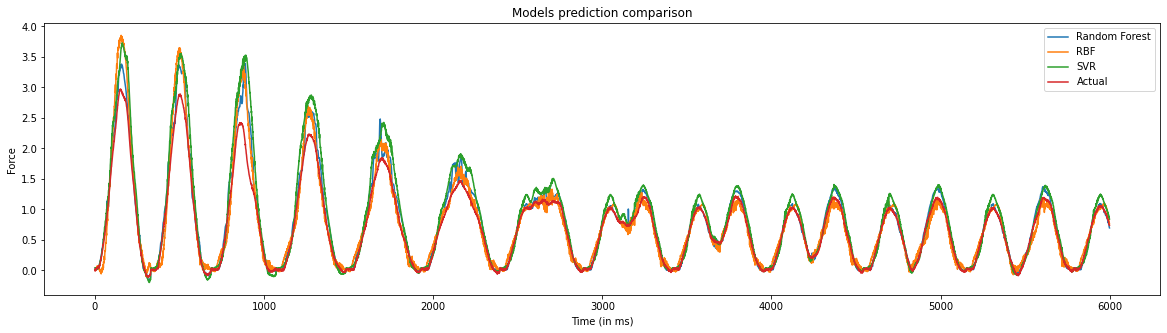

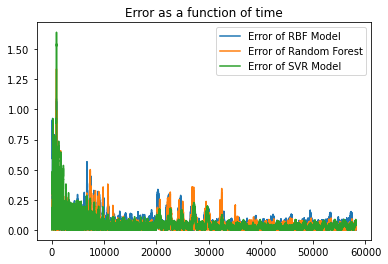

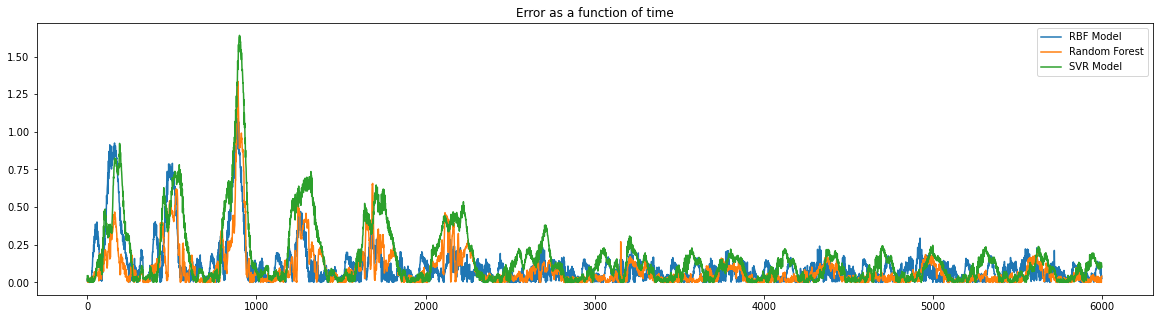

In [7]:
get_results()

In [8]:
# Gradient Boosting Method
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor()
t1 = datetime.now()
gb.fit(x_train,y_train)
t2 = datetime.now()
print('Time taken by Gradient Boosting:',t2-t1)

y_pred = gb.predict(x_test)
print('Root mean square error of Gradient Boosting Model: ',sqrt(mean_squared_error(y_test,y_pred)))

Time taken by Gradient Boosting: 0:01:39.188814
Root mean square error of Gradient Boosting Model:  0.09140537036877701


In [9]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor()
t1 = datetime.now()
cat.fit(x_train,y_train)
t2 = datetime.now()

Learning rate set to 0.086822
0:	learn: 0.9248567	total: 105ms	remaining: 1m 45s
1:	learn: 0.8493298	total: 112ms	remaining: 55.9s
2:	learn: 0.7814290	total: 121ms	remaining: 40.2s
3:	learn: 0.7194026	total: 128ms	remaining: 31.8s
4:	learn: 0.6639401	total: 133ms	remaining: 26.5s
5:	learn: 0.6117036	total: 138ms	remaining: 22.9s
6:	learn: 0.5630509	total: 144ms	remaining: 20.4s
7:	learn: 0.5190099	total: 149ms	remaining: 18.5s
8:	learn: 0.4785451	total: 154ms	remaining: 17s
9:	learn: 0.4420374	total: 161ms	remaining: 16s
10:	learn: 0.4080988	total: 167ms	remaining: 15s
11:	learn: 0.3769202	total: 172ms	remaining: 14.2s
12:	learn: 0.3491072	total: 182ms	remaining: 13.8s
13:	learn: 0.3231697	total: 191ms	remaining: 13.4s
14:	learn: 0.2998369	total: 196ms	remaining: 12.9s
15:	learn: 0.2788479	total: 201ms	remaining: 12.4s
16:	learn: 0.2597674	total: 206ms	remaining: 11.9s
17:	learn: 0.2420596	total: 211ms	remaining: 11.5s
18:	learn: 0.2259909	total: 216ms	remaining: 11.2s
19:	learn: 0.211

In [10]:
print('Time taken by Cat Boosting:',t2-t1)

y_pred = cat.predict(x_test)
print('Root mean square error of Cat Boost Model: ',sqrt(mean_squared_error(y_test,y_pred)))

Time taken by Cat Boosting: 0:00:07.391340
Root mean square error of Cat Boost Model:  0.06586638083997423


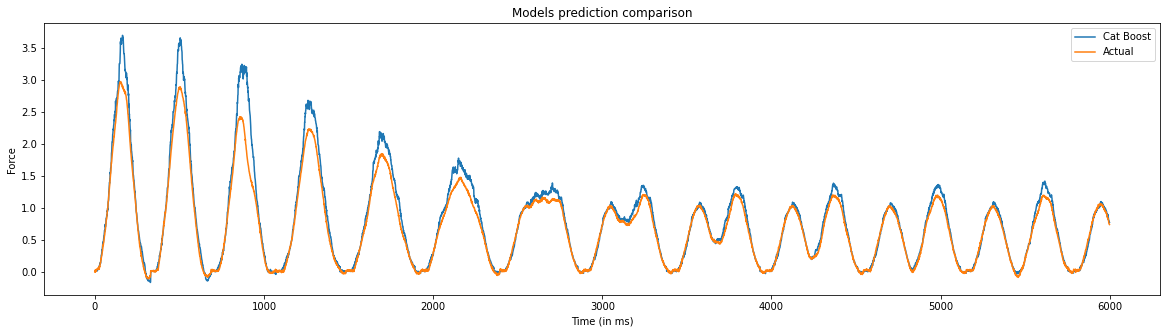

In [11]:
plt.figure(figsize=(20,5))
plt.plot(list(range(6000)),y_pred[:6000], label = 'Cat Boost')
plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
plt.legend()
plt.xlabel('Time (in ms)')
plt.ylabel('Force')
plt.title('Models prediction comparison')
plt.show()